In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install wurlitzer
!pip install tensorflow==2.15.0.post1



# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


2024-06-19 22:15:44.597999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 22:15:44.598071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 22:15:44.600543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow.keras.layers as layers


In [3]:
from tensorflow.keras.layers.experimental import preprocessing



In [4]:
import os

In [5]:
!mkdir data

In [6]:
import tarfile
zip_file = tarfile.open("/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar")
zip_file.extractall("./data")
zip_file.close()

In [7]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

Text(0.5, 1.0, 'Mask')

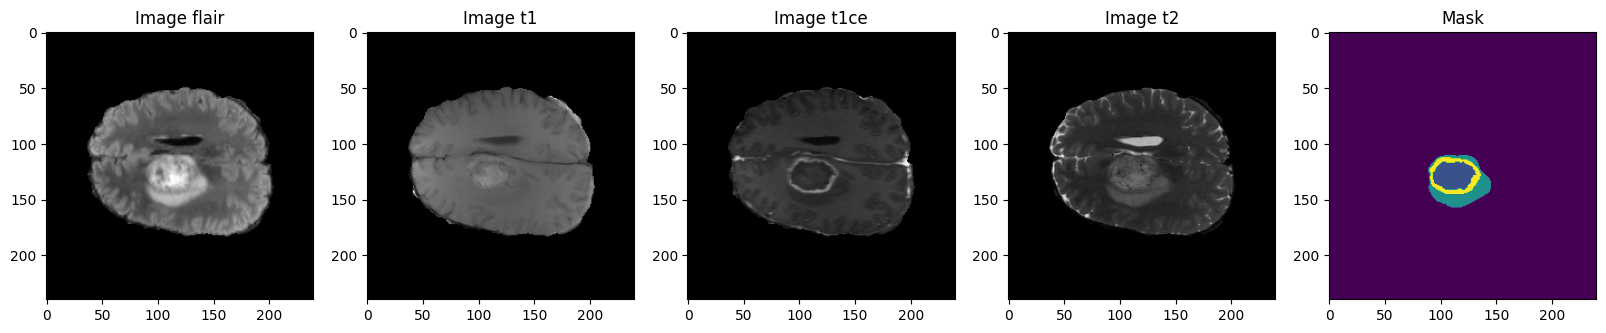

In [8]:
TRAIN_DATASET_PATH = 'data/'
VALIDATION_DATASET_PATH = 'data/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00003/BraTS2021_00003_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00003/BraTS2021_00003_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00003/BraTS2021_00003_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH +'BraTS2021_00003/BraTS2021_00003_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00003/BraTS2021_00003_seg.nii.gz').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

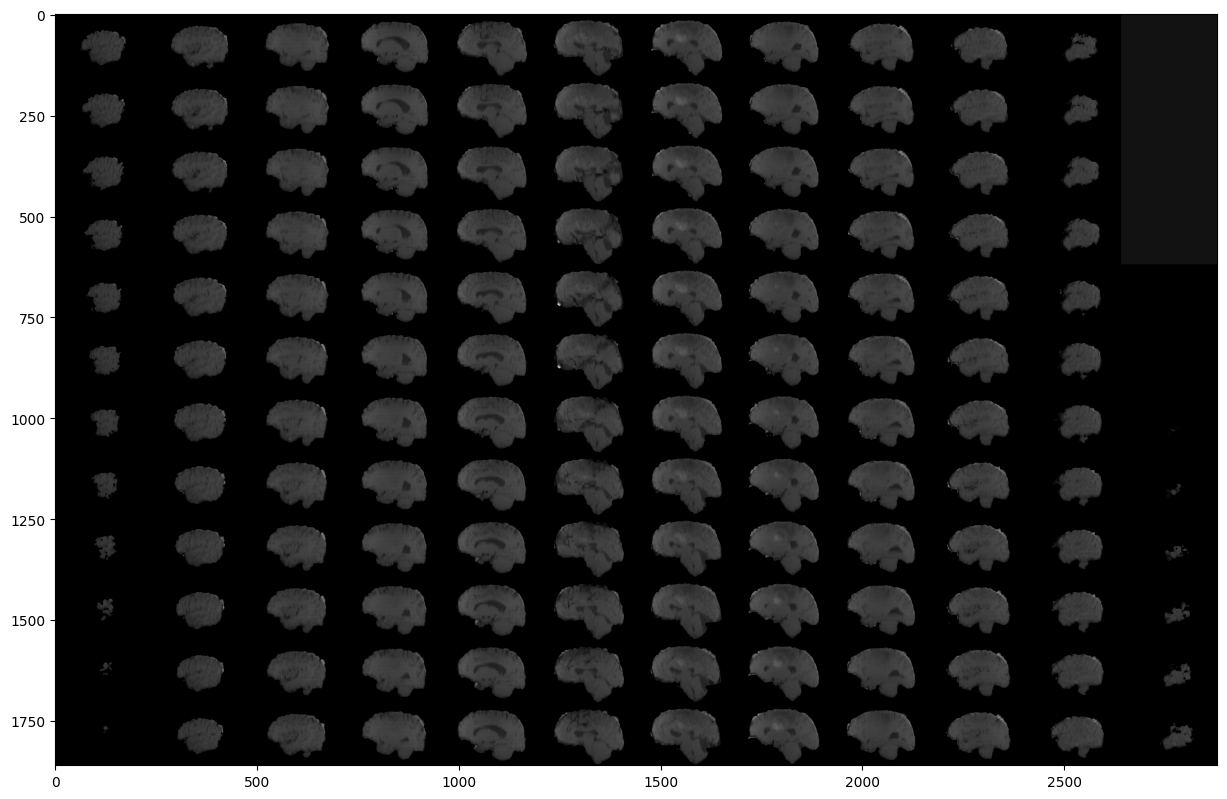

In [9]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

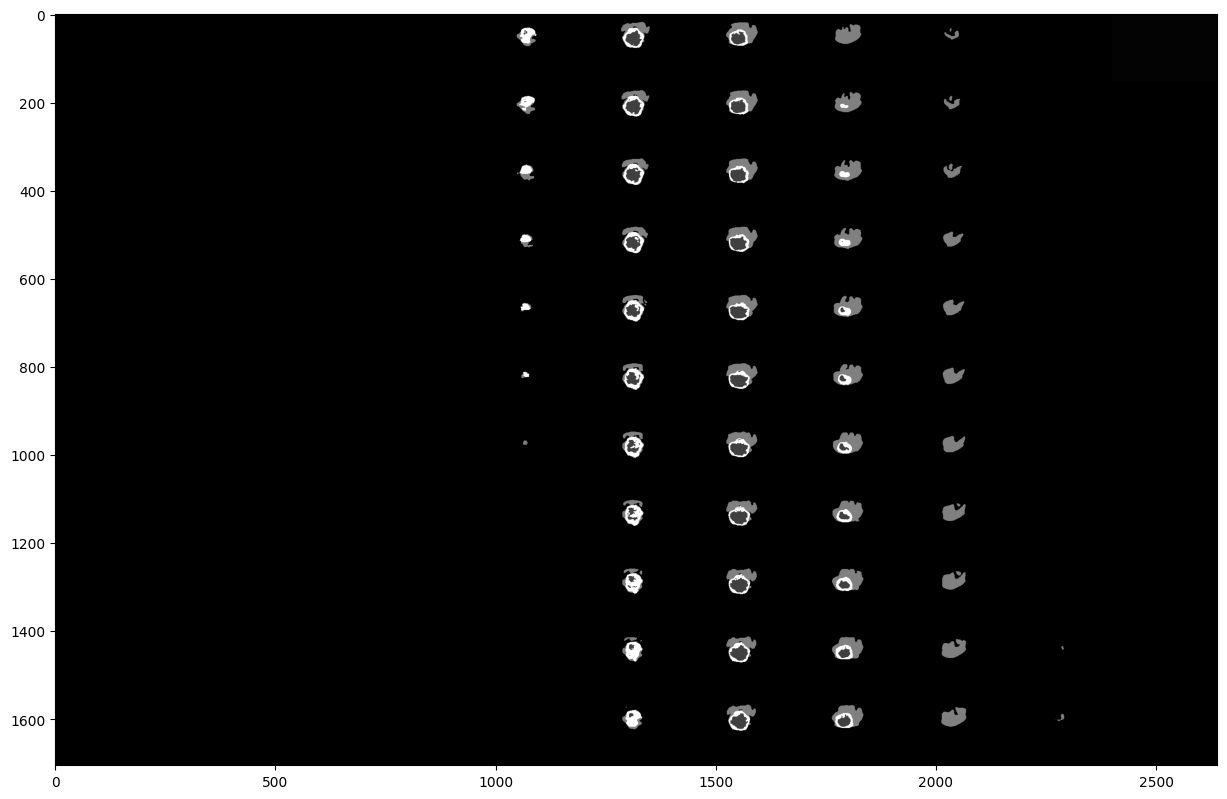

In [10]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

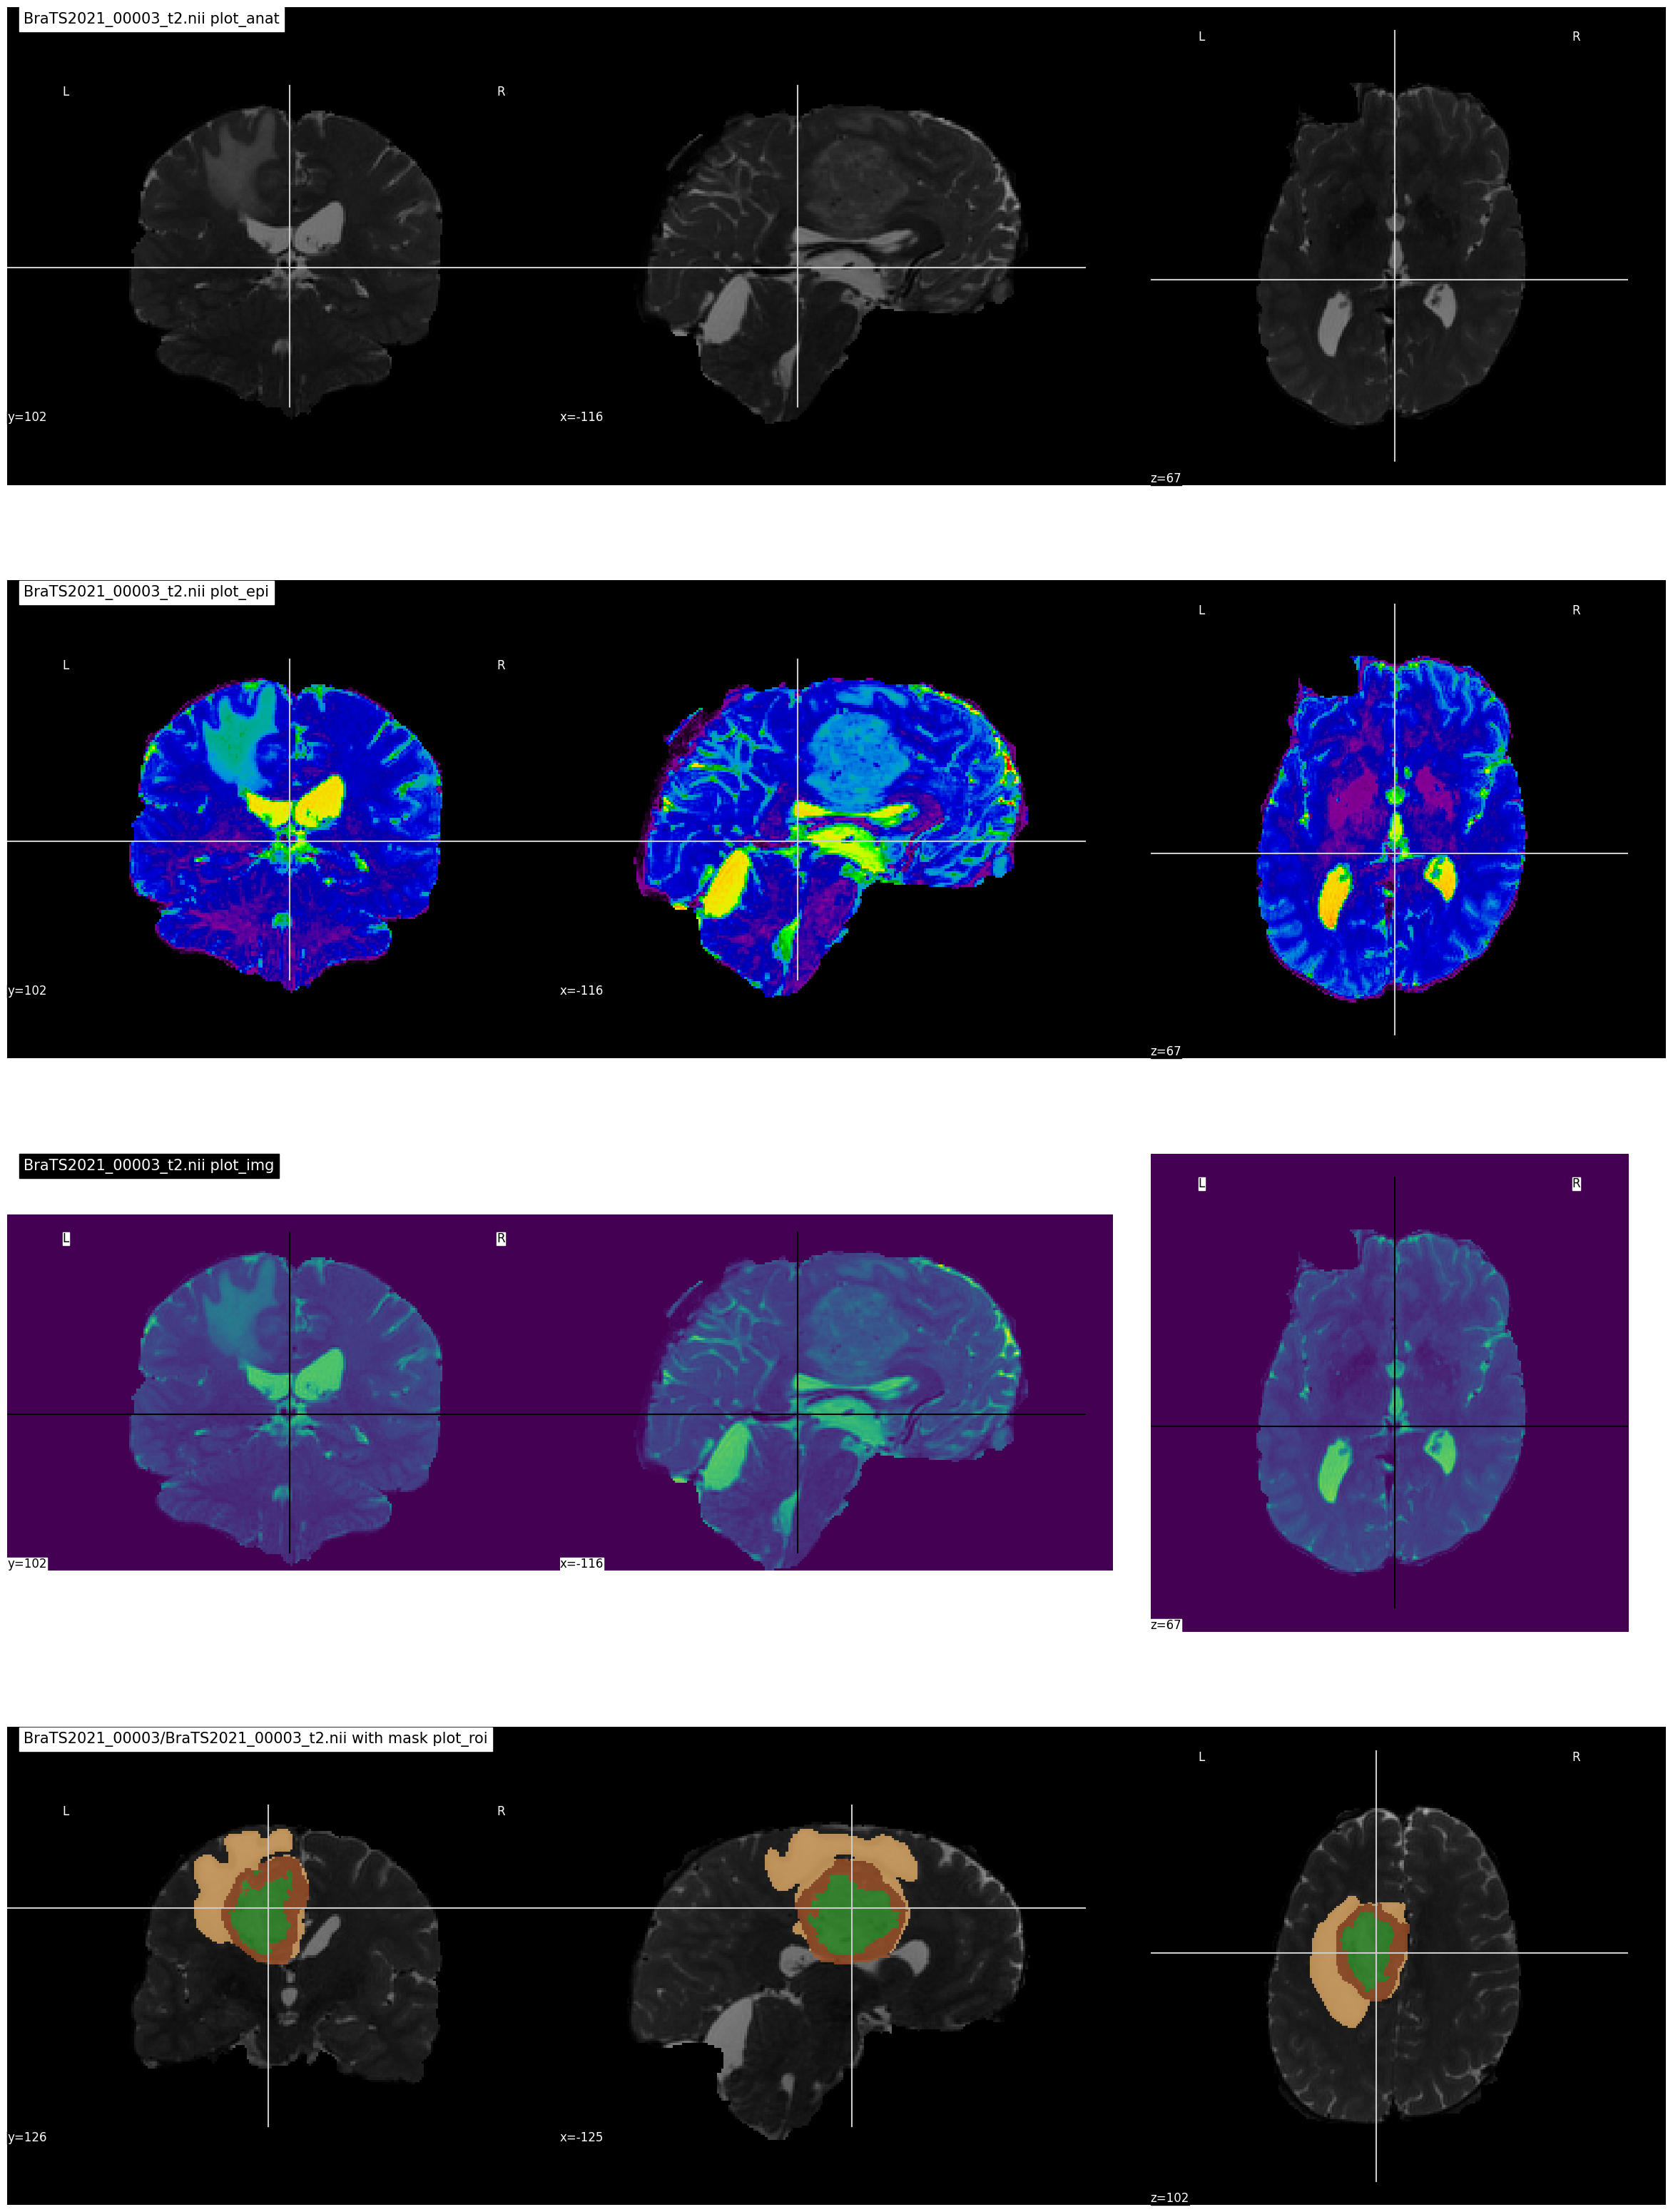

In [11]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_00003/BraTS2021_00003_t2.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_00003/BraTS2021_00003_seg.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS2021_00003_t2.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS2021_00003_t2.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS2021_00003_t2.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS2021_00003/BraTS2021_00003_t2.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [12]:
# dice loss as defined above for 4 classes
def dice_loss(y_true, y_pred, smooth=1.0):
#     print(type(y_true))
#     print(type(y_pred))
#     print(dice_loss_monai(y_true, y_pred))
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
#         print(dice_loss_monai(y_true_f, y_pred_f))
 
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return 1 - total_loss

 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_loss_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return 1 - (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_loss_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return 1 - (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_loss_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return 1 - (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [13]:
IMG_SIZE=128

In [14]:
def build_resunet(inputs, ker_init='he_normal', dropout=0.5):
    # Contracting path
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    conv1 = BatchNormalization()(conv1)
    shortcut1 = Conv2D(32, 1, padding='same', kernel_initializer=ker_init)(inputs)
    res1 = Add()([shortcut1, conv1])
    pool1 = MaxPooling2D(pool_size=(2, 2))(res1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    conv2 = BatchNormalization()(conv2)
    shortcut2 = Conv2D(64, 1, padding='same', kernel_initializer=ker_init)(pool1)
    res2 = Add()([shortcut2, conv2])
    pool2 = MaxPooling2D(pool_size=(2, 2))(res2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    conv3 = BatchNormalization()(conv3)
    shortcut3 = Conv2D(128, 1, padding='same', kernel_initializer=ker_init)(pool2)
    res3 = Add()([shortcut3, conv3])
    pool3 = MaxPooling2D(pool_size=(2, 2))(res3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    conv4 = BatchNormalization()(conv4)
    shortcut4 = Conv2D(256, 1, padding='same', kernel_initializer=ker_init)(pool3)
    res4 = Add()([shortcut4, conv4])
    pool4 = MaxPooling2D(pool_size=(2, 2))(res4)

    # Bottom
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Expanding path
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(up6)
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([res4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)
    conv6 = BatchNormalization()(conv6)
    up6_res = Conv2D(256, 1, padding='same', kernel_initializer=ker_init)(up6)
    res6 = Add()([up6_res, conv6])

    up7 = UpSampling2D(size=(2, 2))(res6)
    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(up7)
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([res3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
    conv7 = BatchNormalization()(conv7)
    up7_res = Conv2D(128, 1, padding='same', kernel_initializer=ker_init)(up7)
    res7 = Add()([up7_res, conv7])

    up8 = UpSampling2D(size=(2, 2))(res7)
    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(up8)
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([res2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)
    conv8 = BatchNormalization()(conv8)
    up8_res = Conv2D(64, 1, padding='same', kernel_initializer=ker_init)(up8)
    res8 = Add()([up8_res, conv8])

    up9 = UpSampling2D(size=(2, 2))(res8)
    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(up9)
    up9 = BatchNormalization()(up9)
    merge9 = concatenate([res1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)
    conv9 = BatchNormalization()(conv9)
    up9_res = Conv2D(32, 1, padding='same', kernel_initializer=ker_init)(up9)
    res9 = Add()([up9_res, conv9])

    # Output layer
    conv10 = Conv2D(4, (1,1), activation='softmax')(res9)

    return Model(inputs=inputs, outputs=conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model2 = build_resunet(input_layer, 'he_normal', 0.2)
model2.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_loss, precision, sensitivity, specificity, dice_loss_necrotic, dice_loss_edema ,dice_loss_enhancing] )

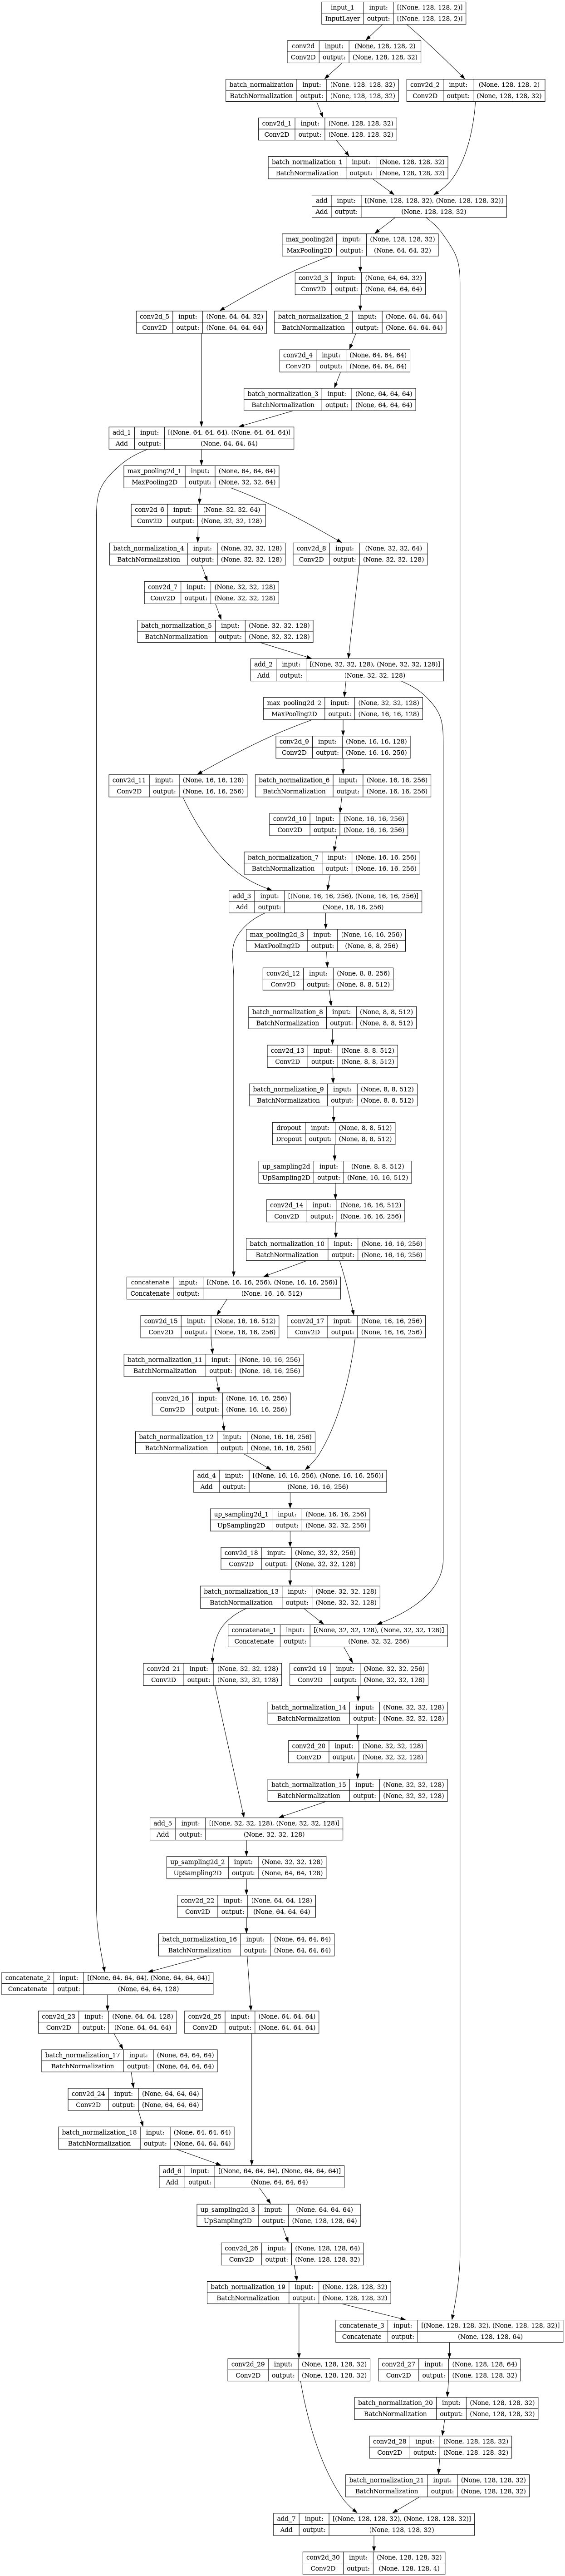

In [15]:
plot_model(model2, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = True, 
           dpi = 70)

In [16]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# # file BraTS20_Training_355 has ill formatted name for for seg.nii file
# train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.2) 

In [17]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

800
251
200


In [18]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

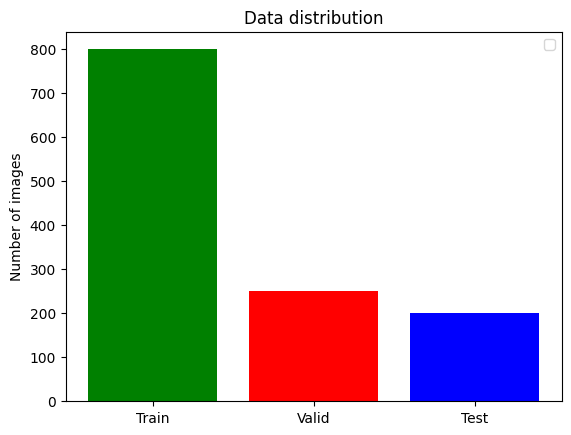

In [19]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [20]:
csv_logger = CSVLogger('training2.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [21]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         608       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['batch_normalization[0][0

In [22]:
K.clear_session()
history =  model2.fit(training_generator,
                     epochs=35,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  
model2.save("model_run2.h5")

Epoch 1/35


2024-06-19 22:18:06.329101: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1718835520.584055      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 [==============================] - 957s 1s/step - loss: 0.1206 - accuracy: 0.9774 - mean_io_u: 0.3755 - dice_loss: 0.5363 - precision: 0.9772 - sensitivity: 0.9470 - specificity: 0.9959 - dice_loss_necrotic: 0.6738 - dice_loss_edema: 0.3999 - dice_loss_enhancing: 0.4091 - val_loss: 0.1858 - val_accuracy: 0.9602 - val_mean_io_u: 0.3756 - val_dice_loss: 0.5854 - val_precision: 0.9641 - val_sensitivity: 0.9581 - val_specificity: 0.9882 - val_dice_loss_necrotic: 0.6595 - val_dice_loss_edema: 0.7863 - val_dice_loss_enhancing: 0.5641 - lr: 0.0010
Epoch 2/35
800/800 [==============================] - 896s 1s/step - loss: 0.0201 - accuracy: 0.9935 - mean_io_u: 0.3755 - dice_loss: 0.3892 - precision: 0.9938 - sensitivity: 0.9923 - specificity: 0.9979 - dice_loss_necrotic: 0.4887 - dice_loss_edema: 0.2685 - dice_loss_enhancing: 0.2439 - val_loss: 0.1129 - val_accuracy: 0.9718 - val_mean_io_u: 0.3756 - val_dice_loss: 0.5514 - val_precision: 0.9754 - val_sensitivity: 0.9698 - val_specifici

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


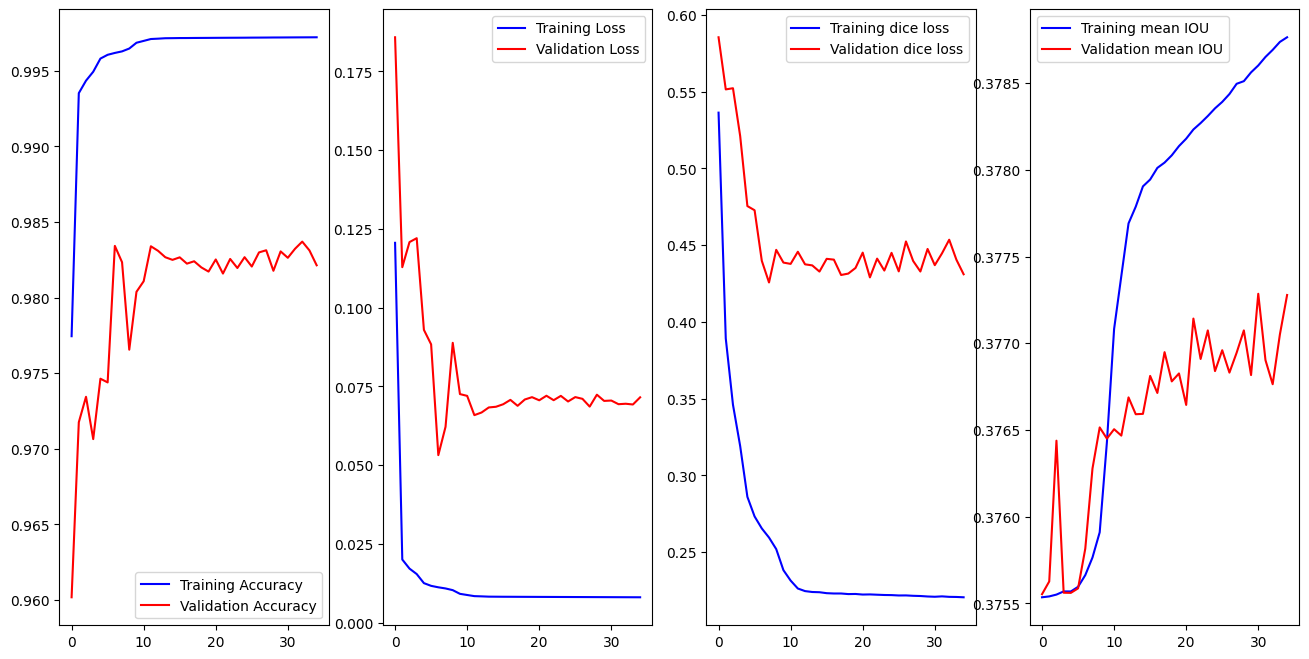

In [23]:
model = keras.models.load_model('/kaggle/working/model_run2.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_loss": dice_loss,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_loss_necrotic": dice_loss_necrotic,
                                                   "dice_loss_edema": dice_loss_edema,
                                                   "dice_loss_enhancing": dice_loss_enhancing
                                                  }, compile=False)

history = pd.read_csv('/kaggle/working/training2.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_loss']
val_dice=hist['val_dice_loss']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice loss')
ax[2].plot(epoch,val_dice,'r',label='Validation dice loss')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [24]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

4/4 [==============================] - 8s 690ms/step


<Figure size 1800x5000 with 0 Axes>

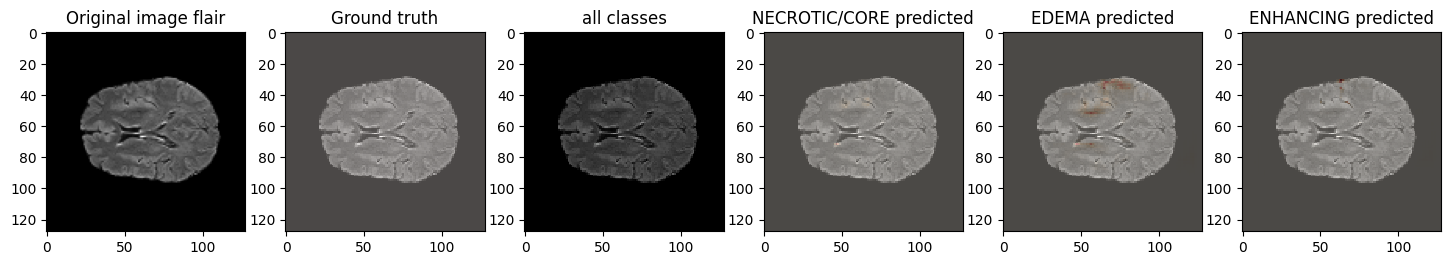

4/4 [==============================] - 0s 60ms/step


<Figure size 1800x5000 with 0 Axes>

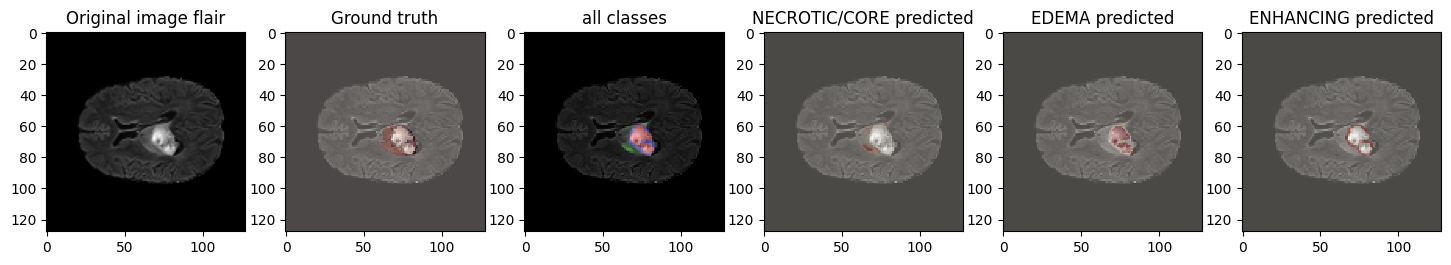

4/4 [==============================] - 0s 60ms/step


<Figure size 1800x5000 with 0 Axes>

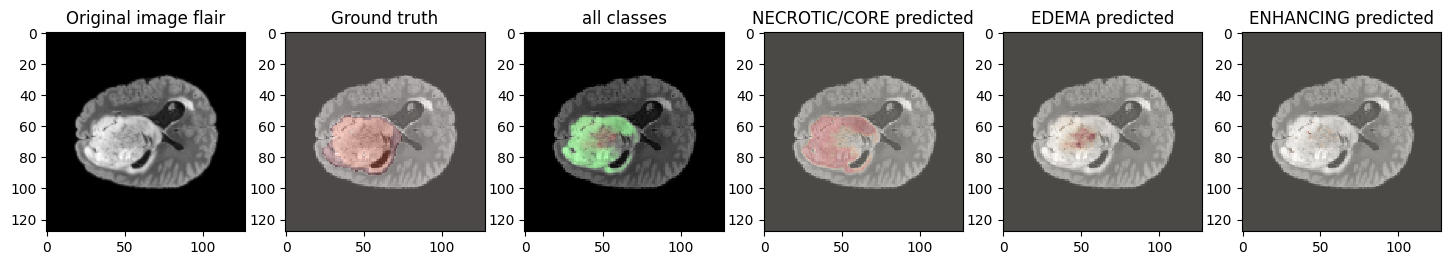

4/4 [==============================] - 0s 60ms/step


<Figure size 1800x5000 with 0 Axes>

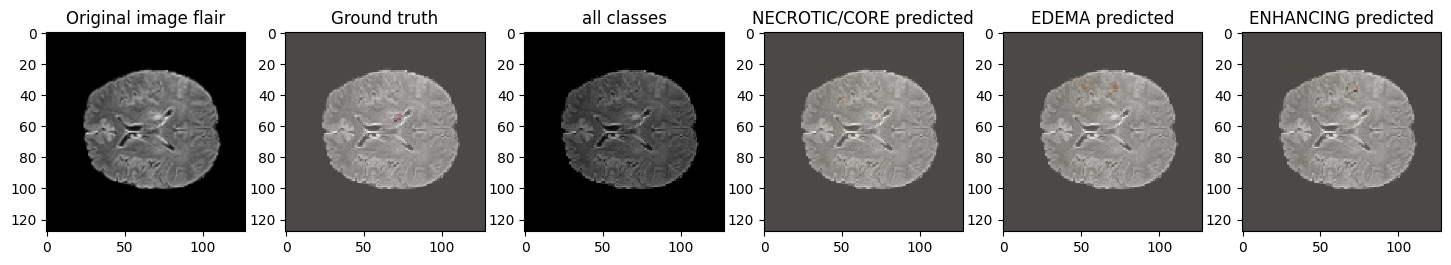

4/4 [==============================] - 0s 62ms/step


<Figure size 1800x5000 with 0 Axes>

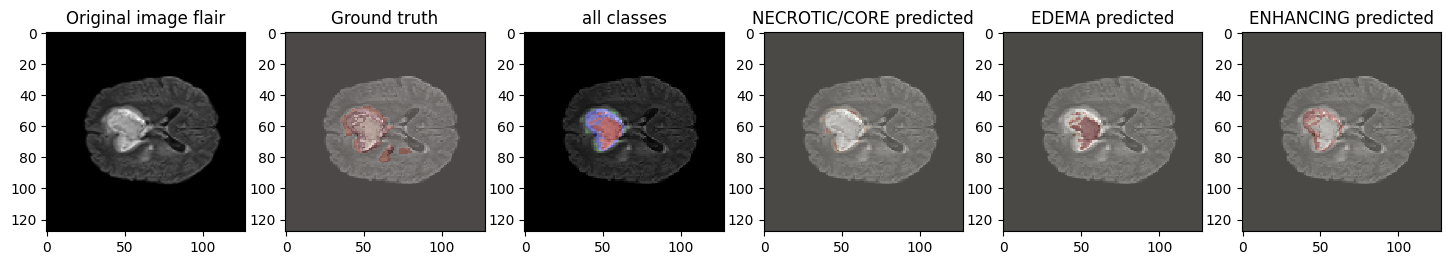

4/4 [==============================] - 0s 79ms/step


<Figure size 1800x5000 with 0 Axes>

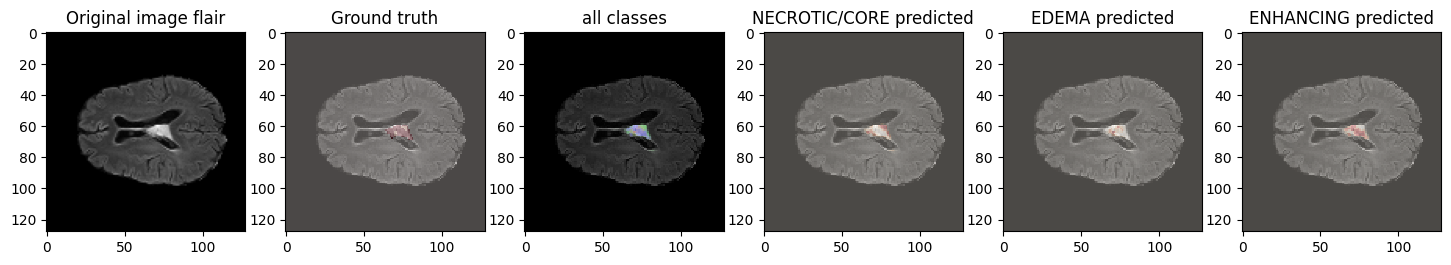

4/4 [==============================] - 0s 61ms/step


<Figure size 1800x5000 with 0 Axes>

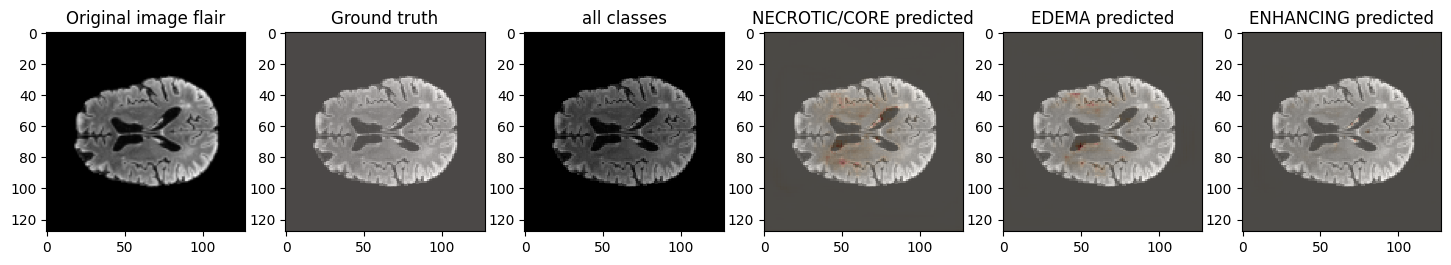

In [25]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'{case}_flair.nii.gz');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'{case}_t1ce.nii.gz');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"data/{case}"
    gt = nib.load(os.path.join(path, f'{case}_seg.nii.gz')).get_fdata()
    origImage = nib.load(os.path.join(path, f'{case}_flair.nii.gz')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
showPredictsById(case=test_ids[0])
showPredictsById(case=test_ids[1])
showPredictsById(case=test_ids[2])
showPredictsById(case=test_ids[3])
showPredictsById(case=test_ids[4])
showPredictsById(case=test_ids[5])
showPredictsById(case=test_ids[6])

4/4 [==============================] - 0s 75ms/step


<Figure size 1800x5000 with 0 Axes>

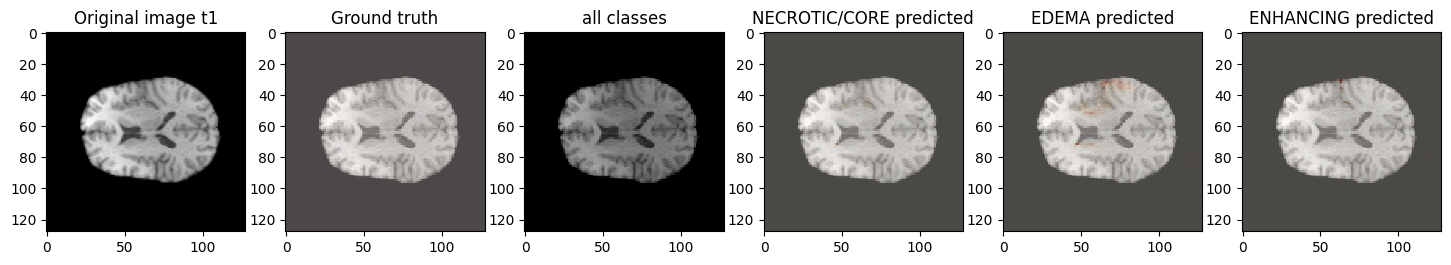

4/4 [==============================] - 0s 61ms/step


<Figure size 1800x5000 with 0 Axes>

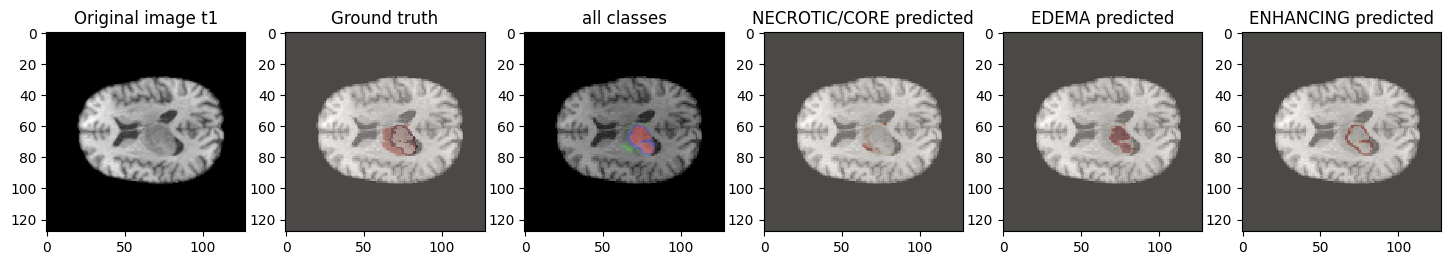

4/4 [==============================] - 0s 61ms/step


<Figure size 1800x5000 with 0 Axes>

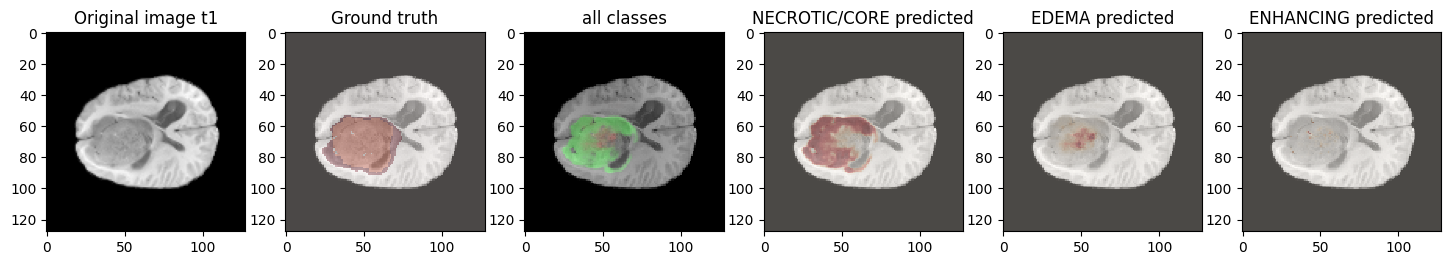

4/4 [==============================] - 0s 63ms/step


<Figure size 1800x5000 with 0 Axes>

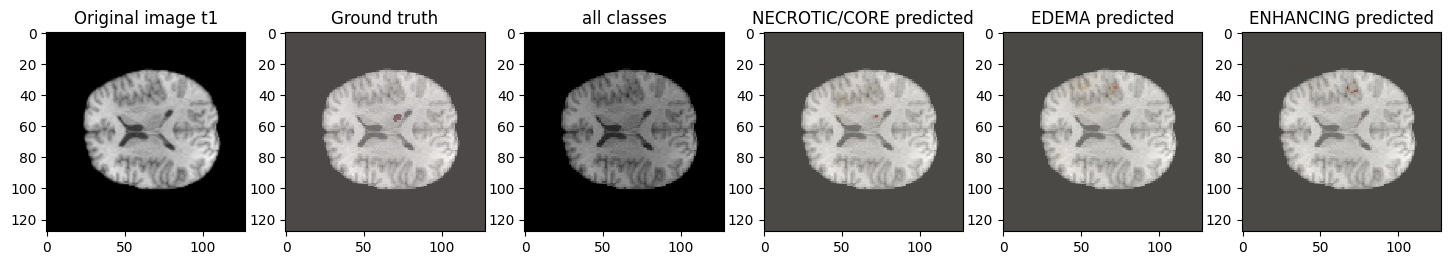

4/4 [==============================] - 0s 61ms/step


<Figure size 1800x5000 with 0 Axes>

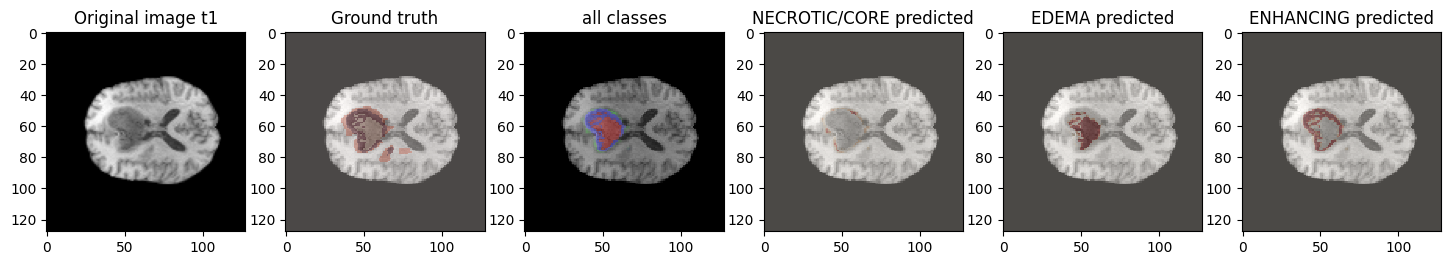

4/4 [==============================] - 0s 61ms/step


<Figure size 1800x5000 with 0 Axes>

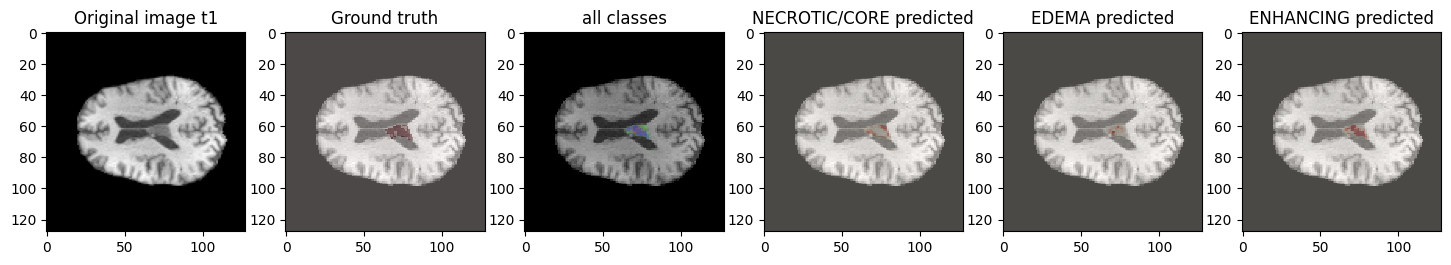

4/4 [==============================] - 0s 62ms/step


<Figure size 1800x5000 with 0 Axes>

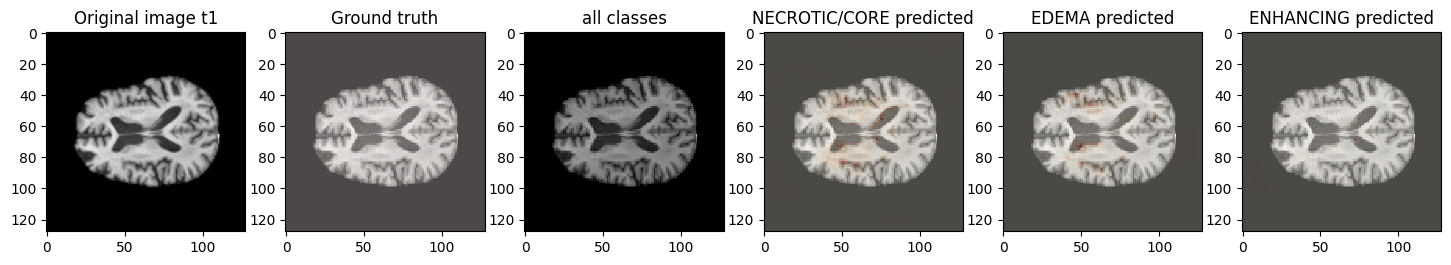

In [26]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'{case}_flair.nii.gz');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'{case}_t1ce.nii.gz');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"data/{case}"
    gt = nib.load(os.path.join(path, f'{case}_seg.nii.gz')).get_fdata()
    origImage = nib.load(os.path.join(path, f'{case}_t1.nii.gz')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image t1')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0])
showPredictsById(case=test_ids[1])
showPredictsById(case=test_ids[2])
showPredictsById(case=test_ids[3])
showPredictsById(case=test_ids[4])
showPredictsById(case=test_ids[5])
showPredictsById(case=test_ids[6])

4/4 [==============================] - 0s 80ms/step


<Figure size 640x480 with 0 Axes>

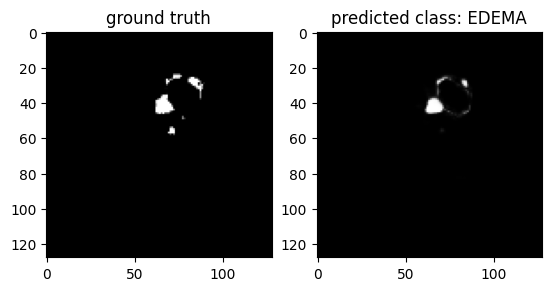

In [27]:
case = case=test_ids[3]
path = f"data/{case}"
gt = nib.load(os.path.join(path, f'{case}_seg.nii.gz')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [28]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_loss, precision, sensitivity, specificity, dice_loss_necrotic, dice_loss_edema, dice_loss_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
200/200 [==============================] - 96s 468ms/step - loss: 0.0675 - accuracy: 0.9838 - mean_io_u_1: 0.3772 - dice_loss: 0.4240 - precision: 0.9843 - sensitivity: 0.9831 - specificity: 0.9948 - dice_loss_necrotic: 0.4554 - dice_loss_edema: 0.5278 - dice_loss_enhancing: 0.4000
test loss, test acc: [0.06751018017530441, 0.983838677406311, 0.37720292806625366, 0.4239949882030487, 0.9843416810035706, 0.9831365942955017, 0.9947962164878845, 0.4554312527179718, 0.5277881622314453, 0.4000234305858612]
